For testing 

In [1]:
import torch
from data import *
import params as par
import matplotlib.pyplot as pl
import numpy as np
from scipy import stats as s
import math 
## Load data to plot
r=torch.load('/home/jb739/sheffield/proj/esn2sparse/data/esn_test.pt')
r.shape

torch.Size([10000, 2800])

torch.Size([10000, 28, 28])
tensor([[ 7],
        [ 9],
        [12],
        [16],
        [20]])
(10000, 100, 28)


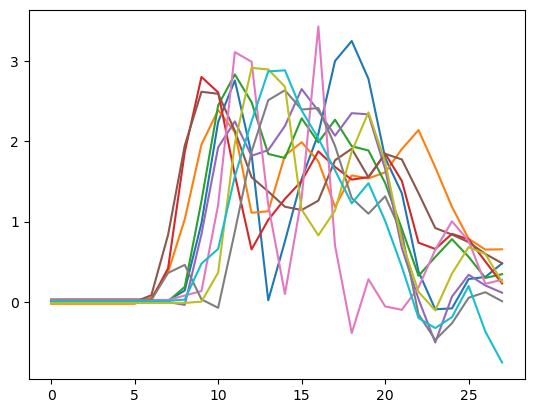

In [2]:
# Extract validation labels
il = seqMNIST(par)
print(f'{il.X_te.shape}')
l = il.label_te
ind = (l==9).nonzero()
print(ind[0:5])
#print(ind)
rr=r.detach().numpy().reshape(10000, 100, 28)
print(rr.shape)
#print(np.max(rr[:]))
fig, ax = pl.subplots()
ax.plot(np.transpose(rr[ind[0:10],0,:].squeeze()))
pl.show()
#ax.plot(np.transpose(s.zscore(rr[ind,0:50], axis=1)))#
#ax.plot(np.transpose(rr[ind,0:50]))

Test the method for extracting anchor, positive and negative samples from input data.

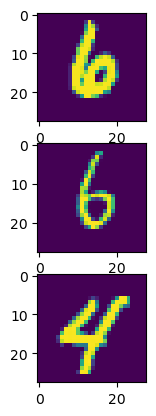

In [84]:
import time
x = il.X_val
label = il.label_val
# Preallocate memory for positive and negative examples
minibatch_size = 20
positive = torch.zeros(minibatch_size, x.shape[1], x.shape[2])
negative = torch.zeros(minibatch_size, x.shape[1], x.shape[2])
# Select anchor samples for this batch
n = 0
N_samp = x.shape[0]
anch_ind = range(n*minibatch_size,min((n+1)*minibatch_size, N_samp))
anchor = torch.clone(x[anch_ind,:])
anch_lab = label[anch_ind]
# Select positive and negative samples for this minibatch
nanch_ind = np.delete(np.arange(0, N_samp), anch_ind) # not anchor indeces
for l in torch.unique(anch_lab):
    indl = anch_lab==l # logical index into anchor
    Nindl = sum(indl)  # no. samples with label l in this batch
    indp = nanch_ind[label[nanch_ind]==l] # index into positive samples
    indn = nanch_ind[label[nanch_ind]!=l] # index into negative samples
    indp = indp[np.random.randint(0, len(indp), Nindl.item())] # Select Nindl indeces for positive samples
    indn = indn[np.random.randint(0, len(indn), Nindl.item())] # Select Nindl indeces for negative samples
    positive[indl,:] = torch.clone(x[indp,:]) # Allocate positive samples
    negative[indl,:] = torch.clone(x[indn,:]) # Allocate negative samples

fig, ax = pl.subplots(3)
j=19
ax[0].imshow(anchor[j,:,:])
ax[1].imshow(positive[j,:,:])
ax[2].imshow(negative[j,:,:])
    


In [3]:
x = torch.load('/home/jb739/sheffield/proj/esn2sparse/data/met_save.pt')
x.shape

torch.Size([1000, 1000, 101])

In [ ]:
Plot MET responses to the same class over time. Compare responses between classes.

(1000, 101)


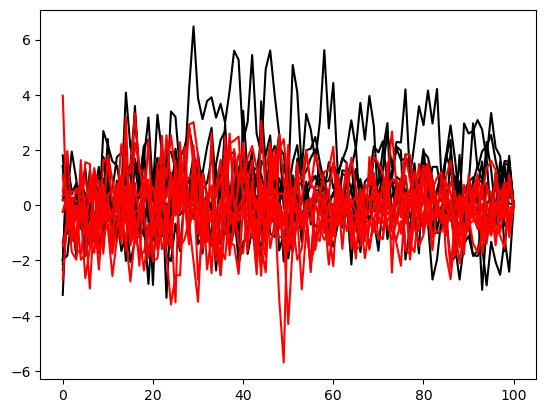

In [4]:

l0 = l==0; l0 = l0[0:1000]
l1 = l==1; l1 = l1[0:1000]
print(x[:,0,:].numpy().shape)
# pl.plot(np.transpose(np.squeeze(np.mean(x[:,0,:].numpy(),0))),'k')
# pl.plot(np.transpose(np.squeeze(np.mean(x[:,1,:].numpy(),0))),'r')
pl.plot(np.transpose(np.squeeze(x[0::100,0,:].numpy())),'k')
pl.plot(np.transpose(np.squeeze(x[0::100,1,:].numpy())),'r')
pl.show()

Check W_esn weight evolution over first training batches.

In [5]:
w = torch.load('/home/jb739/sheffield/proj/esn2sparse/data/wsav.pt')
w.shape

torch.Size([1000, 2800, 101])

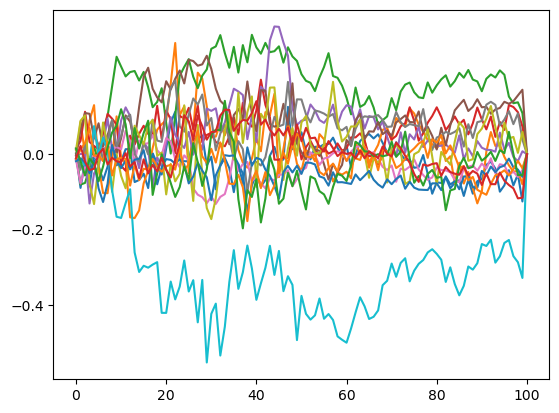

In [14]:
# Weights
pl.plot(np.transpose(torch.squeeze(w[0,0::200,:]).numpy()))
# Absolute rate of change in weights
# pl.plot(np.mean(np.mean(abs(np.diff(torch.squeeze(w[:,0::200,:]).numpy(),axis=2)),1),axis=0))
#pl.imshow(np.squeeze(w[0,:,:]).numpy(),vmin=-0.001,vmax=0.001)
pl.show()

Check for within- and between-classes correlations in ESN responses.

In [51]:
esn = torch.load('/home/jb739/sheffield/proj/esn2sparse/data/esn_test.pt')
print(esn.shape)

torch.Size([10000, 2800])


tensor(892)


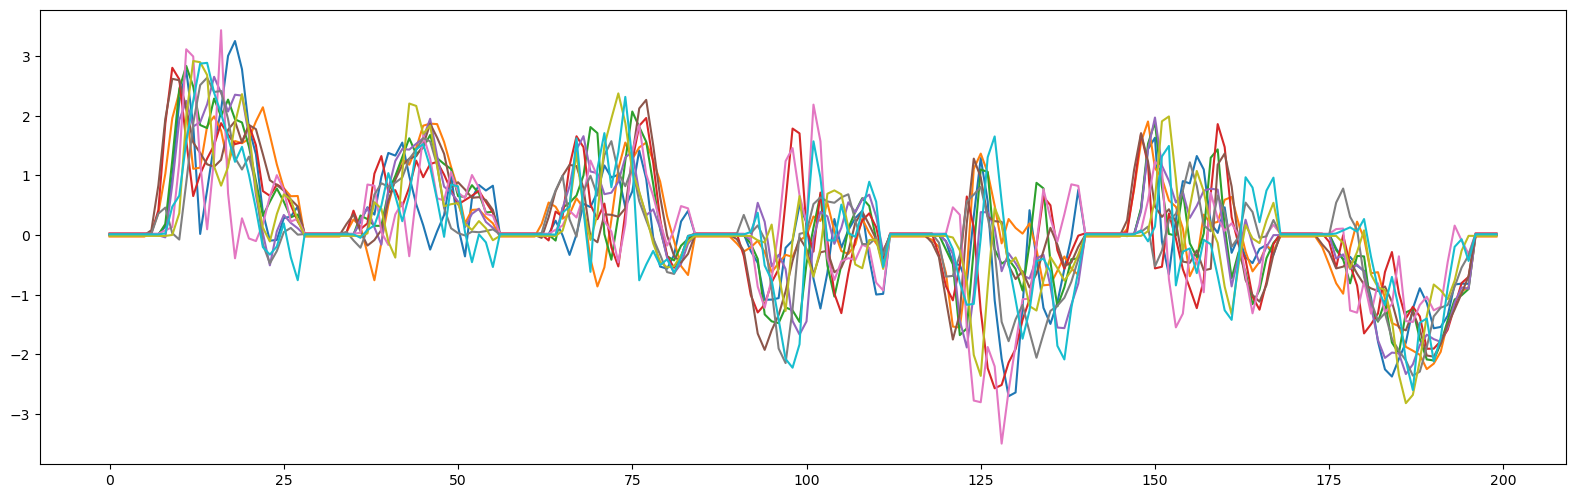

"\nfor k in range(n):\n    print(s.zscore(e1[:,k,:].squeeze().numpy(),1).shape)\n    z1 = s.zscore(e1[:,k,:].squeeze().numpy(),1)\n    z2 = s.zscore(e2[:,k,:].squeeze().numpy(),1)\n    cor[:,:,k] = torch.divide(torch.matmul(torch.tensor(z1), torch.tensor(np.transpose(z2))), 2800.0)\n\nmcor = cor.mean(dim=2)\nprint(mcor.min())\n\n# Class correlations in MET responses\npl.rcParams['svg.fonttype'] = 'none'\nfig = pl.figure(figsize=tuple(np.array((5.,5.))/2.54)); ax = pl.axes()\nimdata = ax.imshow(mcor,vmin=0.2, vmax=0.6)\ncb = fig.colorbar(imdata, ticks=[0.2, 0.6])\nax.xaxis.set_ticks(np.arange(10)); ax.yaxis.set_ticks(np.arange(10))\nax.tick_params(axis='both', which='major', labelsize=6.0)\ncb.ax.tick_params(labelsize=6.0)\npl.savefig('/home/jb739/sheffield/proj/esn2sparse/data/esn_corr.svg', format='svg')\n"

In [74]:
lab = il.label_te
n = torch.tensor(math.inf)
for j in range(10):
    labj = lab == j
    if torch.sum(labj.long())<n:
        n = torch.sum(labj.long())
print(n)
cor = torch.zeros(10,10,n)
e1 = torch.zeros(10,n,2800)
e2 = torch.zeros(10,n,2800)
for j in range(10):
    ind = (lab==j).nonzero()[0:n].squeeze()
    e1[j,:,:] = esn[ind,:]
    e2[j,:,:] = esn[ind[torch.randperm(n)],:]

ee = e1[9,:,:].reshape(n,100,28)
# fig = pl.figure(figsize=tuple(np.array((5.,5.))/2.54)); ax = pl.axes()
# pl.plot(ee[0:10,0,:].transpose(0,1))
fig = pl.figure(figsize=tuple(np.array((50.,15.))/2.54)); ax = pl.axes()
pl.plot(e1[9,0:10,0:200].transpose(0,1))
pl.show()
'''
for k in range(n):
    print(s.zscore(e1[:,k,:].squeeze().numpy(),1).shape)
    z1 = s.zscore(e1[:,k,:].squeeze().numpy(),1)
    z2 = s.zscore(e2[:,k,:].squeeze().numpy(),1)
    cor[:,:,k] = torch.divide(torch.matmul(torch.tensor(z1), torch.tensor(np.transpose(z2))), 2800.0)

mcor = cor.mean(dim=2)
print(mcor.min())

# Class correlations in MET responses
pl.rcParams['svg.fonttype'] = 'none'
fig = pl.figure(figsize=tuple(np.array((5.,5.))/2.54)); ax = pl.axes()
imdata = ax.imshow(mcor,vmin=0.2, vmax=0.6)
cb = fig.colorbar(imdata, ticks=[0.2, 0.6])
ax.xaxis.set_ticks(np.arange(10)); ax.yaxis.set_ticks(np.arange(10))
ax.tick_params(axis='both', which='major', labelsize=6.0)
cb.ax.tick_params(labelsize=6.0)
pl.savefig('/home/jb739/sheffield/proj/esn2sparse/data/esn_corr.svg', format='svg')
'''

Correlation in MET responses

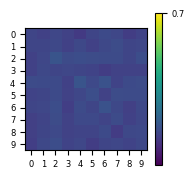

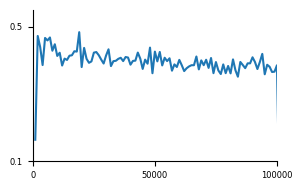

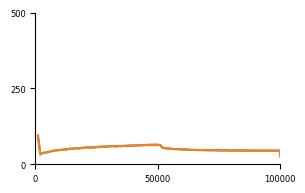

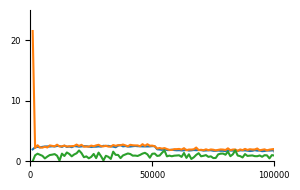

In [6]:
lab = il.label_val[0:1000]
n = torch.tensor(math.inf)
for j in range(10):
    labj = lab == j
    if torch.sum(labj.long())<n:
        n = torch.sum(labj.long())

nt = x.shape[2]
cor = torch.zeros(10,10,n)
xx = torch.zeros(n,10,1000)
mincor = np.zeros(nt,)
for k in range(nt-1):
    for j in range(10):
        ind = ((lab==j).long()*torch.arange(1000))
        if ind[0]==0:
            ind = torch.cat((ind[0:1],ind.nonzero().squeeze()),0)[0:n].squeeze()
        else:
            ind = ind.nonzero()[0:n].squeeze()
            
        xx[:,j,:] = torch.transpose(x[:,ind,k],0,1)
    axx = xx[torch.randperm(n),:,:]
    for j in range(n):   
        if xx[j,:,:].max()==0:
            print(f'....{[k,j]}')
        zxx1 = s.zscore(xx[j,:,:].squeeze().numpy(),1)
        zxx2 = s.zscore(axx[j,:,:].squeeze().numpy(),1)
        if np.isnan(zxx1[:]).any() or np.isnan(zxx2[:]).any():
            print(f'*** {j}')
        cor[:,:,j] = torch.divide(torch.matmul(torch.tensor(zxx1),torch.tensor(np.transpose(zxx2))),1000.0)
    mcor = cor.mean(dim=2)
    weights = np.ones((10,10)) - np.diag(np.zeros(10))
    mincor[k] = np.average(mcor, weights=weights)

# Class correlations in MET responses
pl.rcParams['svg.fonttype'] = 'none'
fig = pl.figure(figsize=tuple(np.array((5.,5.))/2.54)); ax = pl.axes()
imdata = ax.imshow(mcor,vmin=0.3, vmax=0.7)
cb = fig.colorbar(imdata, ticks=[0, 0.7])
ax.xaxis.set_ticks(np.arange(10)); ax.yaxis.set_ticks(np.arange(10))
ax.tick_params(axis='both', which='major', labelsize=6.0)
cb.ax.tick_params(labelsize=6.0)
pl.savefig('/home/jb739/sheffield/proj/esn2sparse/data/corr.svg', format='svg')
# Minimum between-class correlation as a function of training batch
fig = pl.figure(figsize=tuple(np.array((8.,5.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
pl.plot(np.linspace(1,nt,nt)*1000,mincor)
ax.yaxis.set_ticks((0.1,0.5)); ax.xaxis.set_ticks((0,50000,100000))
ax.set_xlim(xmin=0, xmax=100000); ax.set_ylim(ymin=0.1, ymax=0.55)
ax.tick_params(axis='both', which='major', labelsize=6.0)
pl.savefig('/home/jb739/sheffield/proj/esn2sparse/data/mincor.svg', format="svg")
# Anchor-positive and Anchor-negative distances as function of training batch
d = torch.load('/home/jb739/sheffield/proj/esn2sparse/data/met_distances.pt')
fig = pl.figure(figsize=tuple(np.array((8.,5.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
pl.plot(np.linspace(1,nt,nt)*1000,d)
# ax.yaxis.set_ticks((0.0,500,1000,1500)); ax.xaxis.set_ticks((0,50000,100000))
# ax.set_xlim(xmin=0, xmax=100000); ax.set_ylim(ymin=0.0, ymax=500.)
ax.yaxis.set_ticks((0.0,250,500)); ax.xaxis.set_ticks((0,50000,100000))
ax.set_xlim(xmin=0, xmax=100000); ax.set_ylim(ymin=0.0, ymax=500.)
ax.tick_params(axis='both', which='major', labelsize=6.0)
pl.savefig('/home/jb739/sheffield/proj/esn2sparse/data/distances.svg', format="svg")
# Training and validation loss as function of training batch
l = torch.load('/home/jb739/sheffield/proj/esn2sparse/data/met_loss.pt')
fig = pl.figure(figsize=tuple(np.array((8.,5.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
pl.plot(np.linspace(1,nt,nt)*1000,l)
pl.plot(np.linspace(1,nt,nt)*1000,np.maximum(0, d[:,0].numpy() - d[:,1].numpy() + 1.0))
# ax.yaxis.set_ticks((0,100,50)); ax.xaxis.set_ticks((0,50000,100000))
# ax.set_xlim(xmin=0, xmax=100000); ax.set_ylim(ymin=0.0, ymax=100.)
ax.yaxis.set_ticks((0,10,20)); ax.xaxis.set_ticks((0,50000,100000))
ax.set_xlim(xmin=0, xmax=100000); ax.set_ylim(ymin=0.0, ymax=25.)
ax.tick_params(axis='both', which='major', labelsize=6.0)
pl.savefig('/home/jb739/sheffield/proj/esn2sparse/data/losses.svg', format="svg")


Compute distances between anchors and positive/negative samples, and compute loss, as function of time.

torch.Size([1000, 1000, 101])
time 0 of 101
time 1 of 101
time 2 of 101
time 3 of 101
time 4 of 101
time 5 of 101
time 6 of 101
time 7 of 101
time 8 of 101
time 9 of 101
time 10 of 101
time 11 of 101
time 12 of 101
time 13 of 101
time 14 of 101
time 15 of 101
time 16 of 101
time 17 of 101
time 18 of 101
time 19 of 101
time 20 of 101
time 21 of 101
time 22 of 101
time 23 of 101
time 24 of 101
time 25 of 101
time 26 of 101
time 27 of 101
time 28 of 101
time 29 of 101
time 30 of 101
time 31 of 101
time 32 of 101
time 33 of 101
time 34 of 101
time 35 of 101
time 36 of 101
time 37 of 101
time 38 of 101
time 39 of 101
time 40 of 101
time 41 of 101
time 42 of 101
time 43 of 101
time 44 of 101
time 45 of 101
time 46 of 101
time 47 of 101
time 48 of 101
time 49 of 101
time 50 of 101
time 51 of 101
time 52 of 101
time 53 of 101
time 54 of 101
time 55 of 101
time 56 of 101
time 57 of 101
time 58 of 101
time 59 of 101
time 60 of 101
time 61 of 101
time 62 of 101
time 63 of 101
time 64 of 101
time 

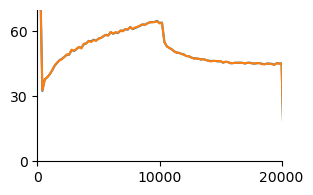

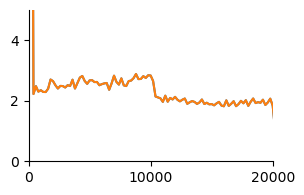

In [18]:
print(x.shape)
label = il.label_val
loss = torch.nn.TripletMarginLoss(1.0)
# Preallocate memory for positive and negative examples
N_samp = x.shape[0]
minibatch_size = 200
N_minibatch = int(np.ceil(N_samp / minibatch_size))
positive = torch.zeros(minibatch_size, x.shape[0])
negative = torch.zeros(minibatch_size, x.shape[0])
dp = torch.zeros(101,1) # anc-pos distance
dn = torch.zeros(101,1) # anc-neg distance
l_torch = torch.zeros(101,1) # pytorch loss
l_my = torch.zeros(101,1) # my loss
for j in range(x.shape[2]):
    d1 = 0.0; d2 = 0.0
    for n in range(N_minibatch):
        # Select anchor samples for this batch
        anch_ind = range(n*minibatch_size,min((n+1)*minibatch_size, N_samp))
        anchor = torch.transpose(torch.clone(x[:,anch_ind,j]),0,1)
        # print(f'anchor shape: {anchor.shape}')
        anch_lab = label[anch_ind]
        # Select positive and negative samples for this minibatch
        nanch_ind = np.delete(np.arange(0, N_samp), anch_ind) # not anchor indeces
        for l in torch.unique(anch_lab):
            indl = anch_lab==l # logical index into anchor
            Nindl = sum(indl)  # no. samples with label l in this batch
            indp = nanch_ind[label[nanch_ind]==l] # index into positive samples
            indn = nanch_ind[label[nanch_ind]!=l] # index into negative samples
            indp = indp[np.random.randint(0, len(indp), Nindl.item())] # Select Nindl indeces for positive samples
            indn = indn[np.random.randint(0, len(indn), Nindl.item())] # Select Nindl indeces for negative samples
            # print(torch.transpose(x[:,indp,j],0,1).shape)
            # print(positive[indl,:].shape)
            positive[indl,:] = torch.transpose(x[:,indp,j],0,1) # Allocate positive samples
            negative[indl,:] = torch.transpose(x[:,indn,j],0,1) # Allocate negative samples
        # Compute mean distances and losses for minibatch n
        temploss = 0.0; tempdp = 0.0; tempdn = 0.0
        for k in range(minibatch_size):
            d1 = torch.dist(anchor[k,:],positive[k,:],2)
            d2 = torch.dist(anchor[k,:],negative[k,:],2)
            tempdp += d1; tempdn += d2; temploss += torch.maximum(torch.tensor(0.0), d1 - d2 + 1.0)
        temploss /= minibatch_size; tempdp /= minibatch_size; tempdn /= minibatch_size
        l_torch[j] += loss(anchor, positive, negative)
        l_my[j] += temploss
        dp[j] += tempdp
        dn[j] += tempdn
    # Compute mean distances and losses for time point j
    l_torch[j] /= N_minibatch; l_my[j] /= N_minibatch; dp[j] /= N_minibatch; dn[j] /= N_minibatch
    print(f'time {j} of 101')




Plot distances and losses from above cell

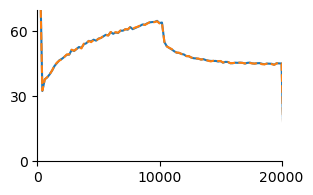

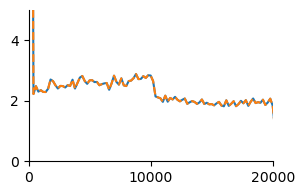

In [20]:
# Plot distances and losses
nt = x.shape[2]
fig = pl.figure(figsize=tuple(np.array((8.,5.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
pl.plot(np.linspace(1,nt,nt)*200,dp); pl.plot(np.linspace(1,nt,nt)*200,dn, linestyle='dashed'); 
ax.set_xlim(xmin=0, xmax=20000); ax.set_ylim(ymin=0.0, ymax=70.)
ax.xaxis.set_ticks((0,10000,20000)); ax.yaxis.set_ticks((0,30,60));
pl.show()
fig = pl.figure(figsize=tuple(np.array((8.,5.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
pl.plot(np.linspace(1,nt,nt)*200,l_torch); pl.plot(np.linspace(1,nt,nt)*200,l_my, linestyle='dashed')
ax.set_xlim(xmin=0, xmax=20000); ax.set_ylim(ymin=0.0, ymax=5.)
ax.xaxis.set_ticks((0,10000,20000)); ax.yaxis.set_ticks((0,2,4))
pl.show()